After we have cleaned data, let's start building **Prediction Models** to find which is the best for our goals!

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Feature-Selection" data-toc-modified-id="Feature-Selection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature Selection</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#Fix-Imbalance" data-toc-modified-id="Fix-Imbalance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fix Imbalance</a></span></li><li><span><a href="#Model-Training" data-toc-modified-id="Model-Training-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Training</a></span></li><li><span><a href="#Finalizing-and-Saving-Model" data-toc-modified-id="Finalizing-and-Saving-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Finalizing and Saving Model
    </a></span></li></ul></div>

# Import Libraries

In [11]:
#import the required libraries
import numpy as np 
import pandas as pd 
import seaborn as sns 

# For Modeling
from pycaret.classification import predict_model
from IPython.display import display, HTML
from sklearn.preprocessing import LabelEncoder
import matplotlib.ticker as mtick  
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.feature_selection import SelectKBest
from xgboost import XGBClassifier
from collections import Counter
from imblearn.combine import SMOTEENN

%matplotlib inline

plt.style.use('default')
import warnings
warnings.filterwarnings("ignore")

### Reading data

In [12]:
#load previous cleaned data from EDA
df = pd.read_csv('tel_churn_clean.csv')
df.head()

,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,1,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,2,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,3,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,4,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


In [13]:
#remove unnamed column which unnecessary for model
df = df.drop('Unnamed: 0',axis=1)

In [16]:
x = df.drop('Churn',axis=1)
x

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80,1990.50
7028,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20,7362.90
7029,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60,346.45
7030,1,1,1,0,4,1,2,1,0,0,0,0,0,0,0,1,3,74.40,306.60


In [17]:
y = df['Churn']
y

0       0
1       0
2       1
3       0
4       1
       ..
7027    0
7028    0
7029    0
7030    1
7031    0
Name: Churn, Length: 7032, dtype: int64

In [18]:
#its imbalance dataset
y.value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

In [44]:
df['tenure'].min()

1

# Feature Selection

Selecting only 7 features which has higher correlation with churn

In [19]:
select_feature=SelectKBest(k=7) #no of features to be select
select_feature.fit(x,y)

SelectKBest(k=7)

In [21]:
#Top 10 high correlated features
select_feature.get_feature_names_out()

array(['tenure', 'OnlineSecurity', 'OnlineBackup', 'TechSupport',
       'Contract', 'MonthlyCharges', 'TotalCharges'], dtype=object)

In [22]:
x = x[select_feature.get_feature_names_out()]

In [23]:
x.shape

(7032, 7)

according to the feature selection we have selected 7 top features out of 19 features

# Train Test Split

Let's split data into training and validation set in 80:20 ratio

In [67]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [68]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((5625, 7), (5625,), (1407, 7), (1407,))

In [69]:
#its imbalance dataset
y.value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

In [24]:
#For model evaluation, easier to evaluate

def evaluate_model_performance(model,test_data):
    prediction=model.predict(test_data)
    #print("Training Accurary : ",model.score(x_train,y_train))
    print("Validation Accurary : {:.2f} %".format(accuracy_score(y_test,prediction)))
    print("Precision Score : {:.2f} %".format(precision_score(y_test,prediction)))
    print("Recall Score : {:.2f} %".format(recall_score(y_test,prediction)))
    print("F1 Score : {:.2f} %".format(f1_score(y_test,prediction)))
    print(classification_report(y_test,prediction))

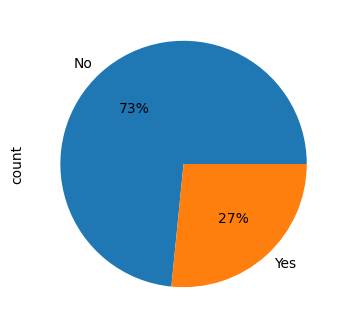

In [25]:
plt.figure(figsize=(8,4))
y.value_counts().plot(kind="pie",autopct="%1.f%%",labels=['No','Yes'])
plt.show()

We have 2 classes *class 0 and class 1*.
**class 0 - majority class**,
**class 1 -minority class**

# Fix Imbalance
Using **Upsampling + ENN** to balanced data before train model

In [26]:
# Print the class distribution before applying SMOTE-ENN
print("Before SMOTE-ENN:", Counter(y))


# Apply SMOTE-ENN : fix imbalanced data
smote = SMOTEENN(random_state=42)
x_st, y_st = smote.fit_resample(x, y)


# Print the class distribution after applying SMOTE-ENN
print("After SMOTE-ENN:", Counter(y_st))


Before SMOTE-ENN: Counter({0: 5163, 1: 1869})
After SMOTE-ENN: Counter({1: 3056, 0: 2696})


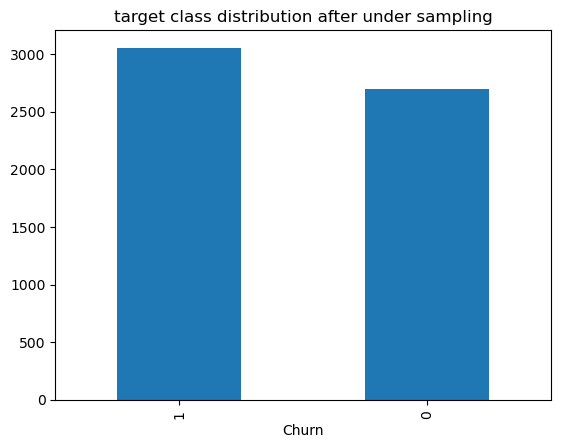

In [27]:
y_st.value_counts().plot(kind="bar")
plt.title("target class distribution after under sampling")
plt.show()

In [20]:
y_st.value_counts()

Churn
1    3056
0    2696
Name: count, dtype: int64

since we have performed SMOTEENN (combination of Smote + ENN) sampling method and we can see our dataset is nearly balanced

### Now split training and validation set using balanced dataset

In [28]:
x_train,x_test,y_train,y_test=train_test_split(x_st,y_st,test_size=0.2,random_state=42)

In [22]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((4601, 7), (4601,), (1151, 7), (1151,))

Building Model with Balanced Dataset and performance hyper parameter tuning using RandomSearchCV

# Model Training

In this case, I am using top best 3 model to compare: 
1. Random Forest Classifier
2. XGBoost Classifier
3. Gradient Boosting Classifier

## 1. Random Forest Classifier

In [37]:
#Finding best hyper parameters using Randomized Search CV

param_grid={'n_estimators':[40,80,120,160,200],
            'max_depth':[2,4,6,8,10],
            "criterion":['gini'],
            "random_state":[27,42,43]
            }
random_search_cv=RandomizedSearchCV( estimator=RandomForestClassifier(), param_distributions=param_grid,n_iter=12,cv=5,scoring='f1',verbose=1)
random_search_cv.fit(x_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=12,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': [2, 4, 6, 8, 10],
                                        'n_estimators': [40, 80, 120, 160, 200],
                                        'random_state': [27, 42, 43]},
                   scoring='f1', verbose=1)

In [44]:
random_search_cv.best_params_

{'random_state': 42, 'n_estimators': 160, 'max_depth': 10, 'criterion': 'gini'}

In [46]:
print('Best Parameters:', random_search_cv.best_params_)

Best Parameters: {'random_state': 42, 'n_estimators': 160, 'max_depth': 10, 'criterion': 'gini'}


In [47]:
#Get final model with best param from RandomizedSearchCV
rf_final_model=random_search_cv.best_estimator_

In [48]:
#evaluate Random Forest Classifier
evaluate_model_performance(rf_final_model,x_test)

Validation Accurary : 0.96 %
Precision Score : 0.95 %
Recall Score : 0.96 %
F1 Score : 0.96 %
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       551
           1       0.95      0.96      0.96       600

    accuracy                           0.96      1151
   macro avg       0.96      0.96      0.96      1151
weighted avg       0.96      0.96      0.96      1151



## 2. XGBoost Classifier

In [50]:
#Finding best hyper parameters using Randomized Search CV

param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'objective': ['binary:logistic']
}

# Create RandomizedSearchCV for XGBoost
RandomizedSearch_xg_cv = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_distributions=param_grid,
    cv=5,
    scoring='accuracy',
    random_state=42
)

# Fit RandomizedSearchCV
RandomizedSearch_xg_cv.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           random_state=42, ...),
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'max_depth': [2, 4, 6, 8],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300],
                                        'objective': ['binary:logistic'],
                                        'reg_alpha': [0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0, 0.1, 0.5, 1.0],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='accuracy')

In [51]:
RandomizedSearch_xg_cv.best_params_

{'subsample': 0.8,
 'reg_lambda': 0.1,
 'reg_alpha': 0,
 'objective': 'binary:logistic',
 'n_estimators': 300,
 'max_depth': 4,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 0.9}

In [52]:
print('Best Parameters:', RandomizedSearch_xg_cv.best_params_)

Best Parameters: {'subsample': 0.8, 'reg_lambda': 0.1, 'reg_alpha': 0, 'objective': 'binary:logistic', 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.9}


In [53]:
xg_smote_model=RandomizedSearch_xg_cv.best_estimator_

In [54]:
#evaluate Random Forest Classifier
evaluate_model_performance(xg_smote_model,x_test)

Validation Accurary : 0.95 %
Precision Score : 0.94 %
Recall Score : 0.96 %
F1 Score : 0.95 %
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       551
           1       0.94      0.96      0.95       600

    accuracy                           0.95      1151
   macro avg       0.95      0.95      0.95      1151
weighted avg       0.95      0.95      0.95      1151



## 3. Gradient Boosting Classifier

In [31]:
#Finding best hyper parameters using Randomized Search CV

param_grid = {
    'n_estimators':[100, 150, 200, 250, 300],
    'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'loss': ['deviance', 'exponential']
}

RandomizedSearch_cv = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_distributions=param_grid,  # Use param_distributions instead of param_grid
    cv=5,
    scoring='accuracy',
    random_state=42
)

RandomizedSearch_cv.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error', 'mse',
                                                      'mae'],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'loss': ['deviance', 'exponential'],
                                        'max_depth': [2, 4, 6, 8],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300]},
                   random_state=42, scoring='accuracy')

In [32]:
RandomizedSearch_cv.best_params_

{'n_estimators': 250,
 'max_depth': 8,
 'loss': 'exponential',
 'learning_rate': 0.2,
 'criterion': 'friedman_mse'}

In [33]:
print('Best Parameters:', RandomizedSearch_cv.best_params_)

Best Parameters: {'n_estimators': 250, 'max_depth': 8, 'loss': 'exponential', 'learning_rate': 0.2, 'criterion': 'friedman_mse'}


In [34]:
gb_smote_model=RandomizedSearch_cv.best_estimator_

In [45]:
#evaluate Random Forest Classifier
evaluate_model_performance(gb_smote_model,x_test)

Validation Accurary : 0.97 %
Precision Score : 0.97 %
Recall Score : 0.98 %
F1 Score : 0.97 %
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       551
           1       0.97      0.98      0.97       600

    accuracy                           0.97      1151
   macro avg       0.97      0.97      0.97      1151
weighted avg       0.97      0.97      0.97      1151



In [27]:
gb_smote_model = GradientBoostingClassifier(n_estimators=250, max_depth=8, loss='exponential', learning_rate=0.2, criterion='friedman_mse')

As we can see, **Gradient Boosting** have slightly better results than **XGBoost**.

To consider: (first case: GB, second case: XGB)
1. **Accuracy**:
        In the first case, accuracy is 97%, and in the second case, it's 95%. Higher accuracy generally indicates better performance, but it's not the only metric to consider, especially in scenarios with imbalanced classes.

2. **Precision**:
        Precision measures the proportion of true positive predictions among all positive predictions. In the first case, precision is 97%, and in the second case, it's 94%. Higher precision means fewer false positives.

3. **Recall**:
        Recall measures the proportion of true positives that were correctly identified. In the first case, recall is 98%, and in the second case, it's 96%. Higher recall means fewer false negatives.

4. **F1 Score**:
        F1 Score is the harmonic mean of precision and recall. In the first case, it's 97%, and in the second case, it's also 95%. F1 Score provides a balance between precision and recall.

**Tips:**
Given these metrics:

- *If your priority is to minimize false positives (i.e., you want to be very sure that the positive predictions are indeed correct), you might choose the model with higher precision (the first one).*

- *If your priority is to minimize false negatives (i.e., you want to ensure that as many true positives as possible are identified), you might choose the model with higher recall (the first one).*

- *If you want a balance between precision and recall, you might consider the F1 Score, in which case both models perform similarly.*

- *If the classes are imbalanced, consider which metric is more important based on the cost of false positives and false negatives in your specific application.*

In summary, choose the model based on the specific requirements and priorities of your problem, whether it's optimizing for precision, recall, or finding a balance between the two.

# Finalizing and Saving Model

After model evaluation based on matrics aboved, 
we have **Gradient Boosting Model** as the **Final Model**.

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
import joblib

joblib.dump(gb_smote_model, 'gradient_boosting_model.joblib')
loaded_model = joblib.load('gradient_boosting_model.joblib')

Here we go! after we got the final model! Let's create app.py and test it out on Streamlit.